In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import threading
import os
import cPickle as pickle
import logging
import pprint
import glob
import collections
import struct
import json
logging.basicConfig(format='%(asctime)s %(levelname)s: %(message)s', datefmt='%m/%d/%Y %I:%M:%S %p', level=logging.INFO)


In [3]:
logging.info('abc')

07/27/2017 11:37:42 PM INFO: abc


In [4]:
class GeneratorRunner(object):
    "Custom runner that that runs an generator in a thread and enqueues the outputs."

    def __init__(self, generator, placeholders, enqueue_op, close_op):
        self._generator = generator
        self._placeholders = placeholders
        self._enqueue_op = enqueue_op
        self._close_op = close_op

    def _run(self, sess, coord):
        try:
            while not coord.should_stop():
                try:
                    values = next(self._generator)

                    assert len(values) == len(self._placeholders), \
                        'generator values and placeholders must have the same length'

                    feed_dict = {placeholder: value \
                        for placeholder, value in zip(self._placeholders, values)}
                    sess.run(self._enqueue_op, feed_dict=feed_dict)
                except (StopIteration, tf.errors.OutOfRangeError, tf.errors.DeadlineExceededError, tf.errors.CancelledError) as e:
                    logging.warning ("%s %s %s", self.__class__.__name__, "exception:", str(type(e)))
                    try:
                        sess.run(self._close_op)
                    except Exception:
                        pass
                    return
        except Exception as ex:
            if coord:
                logging.info ("%s %s %s %s", self.__class__.__name__, "request stop from", self._run.__name__, str(ex))
                coord.request_stop(ex)
                pass
            else: 
                raise

    def create_threads(self, sess, coord=None, daemon=False, start=False):
        "Called by `start_queue_runners`."

        thread = threading.Thread(
            target=self._run,
            args=(sess, coord))

        if coord:
            coord.register_thread(thread)

        if daemon:
            thread.daemon = True

        if start:
            thread.start()

        return [thread]

def read_batch_generator(
        generator, dtypes, shapes, batch_size,
        queue_capacity=10000,
        allow_smaller_final_batch=False):
    "Reads values from an generator, queues, and batches."

    assert len(dtypes) == len(shapes), 'dtypes and shapes must have the same length'
    logging.info('shapes: %s, types: %s, batchsize: %d', str(shapes), str(dtypes), batch_size)
    queue = tf.FIFOQueue(
        capacity=queue_capacity,
        dtypes=dtypes,
        shapes=shapes)

    placeholders = [tf.placeholder(dtype, shape) for dtype, shape in zip(dtypes, shapes)]

    enqueue_op = queue.enqueue(placeholders)
    close_op = queue.close(cancel_pending_enqueues=True)
    global_close_ops.append(close_op)
    queue_runner = GeneratorRunner(generator, placeholders, enqueue_op, close_op)
    tf.train.add_queue_runner(queue_runner)

    if allow_smaller_final_batch:
        return queue.dequeue_up_to(batch_size)
    else:
        return queue.dequeue_many(batch_size)    

In [5]:

import Queue
class MemoryGenerator(object):
    def __init__(self, daily_data,attrib_data, epochs=np.inf):
        self.daily_data = daily_data
        self.attrib_data = attrib_data        
        self.shuffle=True
        self.epochs = epochs
        self.N = len(self.daily_data)*10
        self.curr_epoch = 1
        self.curr_i = 0
        self.q = Queue.Queue()
        if self.shuffle:
            self.do_shuffle()
    def __iter__(self):
        return self
    def do_shuffle(self):
        idx = np.random.permutation(range(len(self.daily_data)))
        self.daily_data = self.daily_data[idx]     
        self.attrib_data = self.attrib_data[idx]
    def fill_queue(self):
        for _ in range(100):
            i=int(np.random.random()*len(self.daily_data))
            attrib_row=self.attrib_data[i]
            row=self.daily_data[i]
            len1=60
            len2=60
            j=int(np.random.random()*(len(row)-len1-1))
            x=row[j:j+len1]
            part_y=row[j+len1:j+len1+len2]
            y=np.zeros(len2,dtype=np.float32)
            y[:len(part_y)]=part_y
            mask=np.zeros(len2,dtype=np.float32)
            mask[:len(part_y)]=1
            self.q.put((np.concatenate([x,attrib_row]).astype(np.float32),np.array(y,dtype=np.float32),mask))
    def __next__(self):
        return self.next()
    def next(self):
        if self.curr_i >= self.N:
            self.curr_i = 0
            self.curr_epoch += 1
            if self.curr_epoch > self.epochs: raise StopIteration
            if self.shuffle: 
                self.do_shuffle()
        if self.q.empty(): self.fill_queue()
        X, y,mask = self.q.get()
        self.curr_i += 1
        return X, y,mask 


In [6]:
def make_train_readers(daily_data,attrib_data, nrows=None, batchsize=60):
    print daily_data.shape, attrib_data.shape
    train_generator = MemoryGenerator(daily_data,attrib_data)
    return read_batch_generator(train_generator, [tf.float32, tf.float32, tf.float32], 
                                [(72,), (60,),(60,)], batchsize, allow_smaller_final_batch=True),train_generator

In [7]:
locales=sorted([u'en', u'ja', u'de', u'fr', u'zh', u'ru', u'es'])
locale_map={v:u for u,v in enumerate(locales)}
locale_map

{u'de': 0, u'en': 1, u'es': 2, u'fr': 3, u'ja': 4, u'ru': 5, u'zh': 6}

In [8]:
access_map={u'all-access':0, u'mobile-web':1, u'desktop':2}
agent_map={u'all-agents':0, u'spider':1}
access_map,agent_map

({u'all-access': 0, u'desktop': 2, u'mobile-web': 1},
 {u'all-agents': 0, u'spider': 1})

In [9]:
def f_map(series, data_map):
    lst=[]
    keys=list(data_map.keys())
    for k in keys:
        lst.append(series.map(lambda u: (u==k)*1))
    df=pd.concat(lst,axis=1)
    df.columns=[series.name+"_"+u for u in keys]
    return df

In [10]:
def make_data():
    import pandas as pd
    csv_path="../input/newtrain_1.csv"
    data = pd.read_csv(csv_path, nrows=None)
    datecols=[u for u in data.columns if u.startswith("20")]
    daily_data=data[datecols].values.astype(np.float32)
    attrib_data=pd.concat([f_map(data.locale,locale_map),
                           f_map(data.agent,agent_map),
                           f_map(data.access,access_map)],axis=1).values.astype(np.float32)    
    print daily_data.shape,attrib_data.shape
    return daily_data,attrib_data

In [11]:
daily_data,attrib_data=make_data()

(145063, 550) (145063, 12)


In [12]:
if 0:
    global_close_ops = []
    #daily_data,attrib_data=make_data()
    _, generator=make_train_readers(daily_data,attrib_data)
    a,b,c= generator.next()
    print a,b,c    
    print a.shape,b.shape,c.shape


In [13]:
def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = "<stripped %d bytes>" % size
    return strip_def

def show_graph(graph_def, max_const_size=32):
    from IPython.display import clear_output, Image, display, HTML

    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph' + str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:1200px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))


In [14]:
def weight_variable(shape, name):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial, name=name)

def bias_variable(shape, name):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial, name=name)

def dense(x, size, scope, with_activation=True):
    if 1:
        with tf.variable_scope(scope):
            w = weight_variable(shape=[int(x.get_shape()[-1]), size], name=None)
            b = bias_variable(shape=[size], name=None)
            h1 = tf.matmul(x, w) + b
            layer=tf.sigmoid(h1) if with_activation else h1
            print layer.get_shape()
    return layer,w,b

def get_Xy(x_size,y_size):
    X = tf.placeholder("float", shape=[None, x_size], name='input_x')
    l2_scale = tf.placeholder(tf.float32, name='l2_scale')
    y = tf.placeholder("float", shape=[None, y_size], name='input_y')
    mask = tf.placeholder("float", shape=[None, y_size], name='mask')
    return X, y,mask, l2_scale

In [30]:
class MyModel(object):
    def __init__(self, x_size,y_size, n_hiddens,l2_scale,phase=True ):
        self.phase=phase
        n_hiddens=n_hiddens
        self.graph = tf.Graph()
        self.all_denses = []
        with self.graph.as_default(): 
            self.X, self.y, self.mask, self.l2_scale = get_Xy(x_size,y_size)
            assert(x_size == self.X.get_shape()[1])
            with tf.variable_scope("nodes"):
                self.X, self.y, self.loss, self.smape \
                     = self.make_model(x_size=x_size, y_size=y_size, n_hiddens=n_hiddens)

            
            with tf.variable_scope('saver'):
                    self.saver = tf.train.Saver()

            update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
            with tf.variable_scope('optimizer'):
                with tf.control_dependencies(update_ops):
                    self.optimizer = tf.train.AdamOptimizer().minimize(self.loss)
        self._session = None    
    @property
    def session(self): 
        if self._session is None:
            self._session = tf.Session(graph=self.graph)
        return self._session
    
    def close_session(self):
        if self._session is not None:
            self._session.close()
            self._session = None
    def initialize(self, session=None):
        with self.graph.as_default():
            init_op = tf.global_variables_initializer()        
        self.session.run(init_op) 
        return self.session
 
        
    def make_model(self, x_size,y_size, n_hiddens):
        X_raw, y  = self.X, self.y 
        logging.debug ("%s %s", self.__class__.__name__,
                       'input shapes: X={},y={}'.format(X_raw.get_shape(), None if y is None else y.get_shape()))

        h = tf.log(X_raw+1)
        #h=     tf.layers.batch_normalization(h,center=False, scale=True,training=self.phase)

        for i in range(0, len(n_hiddens)):
            n_hidden = n_hiddens[i]
            h, w,b = dense(h, n_hidden,'dense')
            self.all_denses.append((h,w,b))

        logits_sum,_,_=dense(h,y_size,'dense',with_activation=False)
        with tf.variable_scope("loss"):
            epsilon = 1e-7        
            l2_loss = 0
            if 1:  # self.l2_scale > 0:
                logging.info('use l2 reg scale %s', str(self.l2_scale))
                for _,w,_ in self.all_denses:
                    l2_loss = l2_loss + tf.reduce_sum(w ** 2)
                l2_loss = l2_loss * self.l2_scale
                self.l2_loss = l2_loss
            if 1:
                predictions = tf.abs(logits_sum, name='prediction')+1e-6
                float_labels = tf.cast(y, tf.float32)
                this_loss =  tf.abs(predictions - float_labels)/( predictions+float_labels ) 
                this_loss=this_loss*self.mask
                this_loss = tf.identity(2* tf.reduce_sum(this_loss)/tf.reduce_sum(self.mask), name='smape')                          
                loss = this_loss + l2_loss

            logging.info ('%s %s %s', self.__class__.__name__, 'logits shape', logits_sum.get_shape())

        return X_raw, y, loss, this_loss
 
    
    def save(self, prefix, ckpt=1):
        checkpoint_name = '{}/model_{}'.format(prefix, 0)
        self.saver.save(self.session, checkpoint_name, global_step=ckpt)

    def load(self, prefix, ckpt=1):
        self.saver.restore(self.session, '{}/model_{}-{}'.format(prefix, self.model_id, ckpt))


In [31]:
np.sum(daily_data==0),np.sum(daily_data<0),daily_data.max()

(7253349, 0, 67264256.0)

In [32]:
if 0:
    tf.reset_default_graph()
    model = MyModel(x_size=75, y_size=60, n_hiddens=[10,10], l2_scale=0.1)
    model.initialize()
    [n.op for n in model.graph.as_graph_def().node];
    show_graph(model.graph.as_graph_def())

In [33]:
def svd_orthonormal(shape):
    print(shape)
    if len(shape) < 2:
        raise RuntimeError("Only shapes of length 2 or more are supported.")
    flat_shape = (shape[0], np.prod(shape[1:]))
    a = np.random.standard_normal(flat_shape)
    u, _, v = np.linalg.svd(a, full_matrices=False)
    q = u if u.shape == flat_shape else v
    q = q.reshape(shape)
    return q

def get_activations(model, h, X_batch):
    activations = model.session.run(h, feed_dict={model.X:X_batch})
    return activations

def LSUVinit(model, batch):
    # only these layer classes considered for LSUV initialization; add more if needed    
    margin = 0.1
    max_iter = 10
    layers_inintialized = 0
    for h,w,_ in model.all_denses:
        # avoid small layers where activation variance close to zero, esp. for small batches
        if np.prod(h.get_shape()) < 32:
            print(h, 'too small')
            continue
        logging.info('LSUV initializing' + str(h))
        layers_inintialized += 1
        needed_variance = 1.0
        
        # print ('pre',np.sum(model.session.run(np.abs(w))))
        weights = svd_orthonormal(w.get_shape())
        model.session.run(tf.assign(w, weights))
        # print (model.session.run(w),weights)
        # print ('post',np.sum(model.session.run(np.abs(w))),np.sum(np.abs(weights)))        
        acts1 = get_activations(model, h, batch)
        # print (acts1,needed_variance)
        
        var1 = np.var(acts1)
        iter1 = 0
        logging.info('var1 %f', var1)
        while (abs(needed_variance - var1) > margin):
            if np.abs(np.sqrt(var1)) < 1e-7: break  # avoid zero division
            weights /= np.sqrt(var1) / np.sqrt(needed_variance)
            model.session.run(tf.assign(w, weights))
            acts1 = get_activations(model, h, batch)
            var1 = np.var(acts1)
            iter1 += 1
            # print (acts1)
            logging.info('var1 %f', var1)
            if iter1 > max_iter:
                break
    logging.info('LSUV: total layers initialized %d', layers_inintialized)   
    return model


In [34]:

class BN(object):
    def __init__(self, x_size, y_size, n_hiddens, l2_scale=0.0, prefix='./tmp'):
        self.x_size = x_size
        self.y_size=y_size
        self.n_hiddens = n_hiddens
        self.l2_scale = l2_scale
        self.prefix = prefix
    

    def train_one_epoch(self, n_epoch, sess, model, reader, coord):
        count = 0
        loss = []; l2_loss = []
        while not coord.should_stop():
            try:
                if  True:
                    X, y,mask = sess.run(reader)
                    feed_dict = {model.X:X, model.y:y, model.mask:mask, model.l2_scale: self.l2_scale}
                    _, a, aa = model.session.run([model.optimizer, model.loss, model.l2_loss], 
                                                    feed_dict=feed_dict)
                    loss.append(a)
                    l2_loss.append(aa)
                    count += len(y)
                    if count % self.net_train_report_intev == 0:

                        logging.info ('[epoch {}][step {}] AVG LOSS: {}, L2LOSS: {}'.format(
                            n_epoch, count, np.mean(loss), np.mean(l2_loss)))
                        loss = []; l2_loss = []
                        #self.read_params()

                    if count >= self.net_train_eval_intev:
                        return 0
            except tf.errors.OutOfRangeError:
                logging.info (self.__class__.__name__, 'Done with read')
                logging.info (self.__class__.__name__, "request stop from", self.train_one_epoch.__name__)                
                coord.request_stop()
                for o in global_close_ops: sess.run(o)
                return 1                                      
            except:
                raise           
        return 0


    def save_net(self, sess, model, n_epoch):
        model.save(prefix=self.prefix, ckpt=n_epoch)

    def train(self, daily_data,attrib_data, net_round,net_train_report_intev,net_train_eval_intev):
        self.net_train_report_intev=net_train_report_intev
        self.net_train_eval_intev=net_train_eval_intev
        model = MyModel(x_size=self.x_size, y_size=self.y_size, n_hiddens=self.n_hiddens,
                             l2_scale=self.l2_scale)
        model.initialize()
        config = tf.ConfigProto(log_device_placement=True)
        # config.gpu_options.per_process_gpu_memory_fraction = 0.3  # don't hog all vRAM
        # config.operation_timeout_in_ms = 10000  # terminate on long hangs
        with tf.Session(config=config) as sess:
            train_reader,_ = make_train_readers(daily_data,attrib_data,batchsize=batch_size,nrows=None)            
            coord = tf.train.Coordinator()
            threads = tf.train.start_queue_runners(sess=sess, coord=coord)
            res = None
            try:
                if 0:
                    logging.info('Use LSUV initialization')
                    batch = np.concatenate([sess.run(train_reader)[0] for _ in range(100)])
                    LSUVinit(model, batch)
                for j in range(net_round):
                    logging.info ('[epoch {}] start net training'.format(j))
                    if self.train_one_epoch(j, sess, model, train_reader, coord) is None:
                        raise Exception("train error")
                    self.save_net(sess=sess, model=model, n_epoch=0)
            except:
                raise 
            finally:
                logging.info ('%s %s %s', self.__class__.__name__, "request stop from", self.train.__name__)
                for o in global_close_ops: sess.run(o)                
                coord.request_stop()

            coord.join(threads)
            sess.close()
            model.close_session()
            return 

    def read_params(self):
	try:
	    with open('param.txt') as f:
	        m = json.load(f)
 	    a = m["l2_scale"]
	    if self.l2_scale != a: 
		logging.info("Change l2_scale from %e to %e", self.l2_scale, a)
	     	self.l2_scale = a
	except:
	    logging.error('read params failed')


In [35]:
daily_data.shape

(145063, 550)

In [36]:
l2_scale = 1e-8*0

batch_size = 256

if 0: #test
    n_hiddens=[10,10]
    net_round=10
    net_train_report_intev=batch_size*10
    net_train_eval_intev=10000
else:
    n_hiddens=[1024,1024]    
    net_round=200
    net_train_report_intev=batch_size*100
    net_train_eval_intev=batch_size*1000

In [37]:
global_close_ops = []
tf.reset_default_graph()       
model = BN(x_size=72, y_size=60, n_hiddens=n_hiddens, prefix='tmp_pred60_1024', l2_scale=l2_scale)
model.train(daily_data,attrib_data,  \
           net_round=net_round,  net_train_report_intev=net_train_report_intev,
            net_train_eval_intev=net_train_eval_intev )  

07/28/2017 12:11:21 AM INFO: use l2 reg scale Tensor("l2_scale:0", dtype=float32)
07/28/2017 12:11:21 AM INFO: MyModel logits shape (?, 60)


(?, 1024)
(?, 1024)
(?, 60)
(145063, 550) (145063, 12)


07/28/2017 12:11:23 AM INFO: shapes: [(72,), (60,), (60,)], types: [tf.float32, tf.float32, tf.float32], batchsize: 256
07/28/2017 12:11:23 AM INFO: [epoch 0] start net training
07/28/2017 12:11:33 AM INFO: [epoch 0][step 25600] AVG LOSS: 1.4405579567, L2LOSS: 0.0
07/28/2017 12:11:44 AM INFO: [epoch 0][step 51200] AVG LOSS: 1.31571376324, L2LOSS: 0.0
07/28/2017 12:11:55 AM INFO: [epoch 0][step 76800] AVG LOSS: 1.12622153759, L2LOSS: 0.0
07/28/2017 12:12:05 AM INFO: [epoch 0][step 102400] AVG LOSS: 1.00404655933, L2LOSS: 0.0
07/28/2017 12:12:16 AM INFO: [epoch 0][step 128000] AVG LOSS: 0.950609028339, L2LOSS: 0.0
07/28/2017 12:12:27 AM INFO: [epoch 0][step 153600] AVG LOSS: 0.905985355377, L2LOSS: 0.0
07/28/2017 12:12:37 AM INFO: [epoch 0][step 179200] AVG LOSS: 0.876792371273, L2LOSS: 0.0
07/28/2017 12:12:48 AM INFO: [epoch 0][step 204800] AVG LOSS: 0.857702076435, L2LOSS: 0.0
07/28/2017 12:12:59 AM INFO: [epoch 0][step 230400] AVG LOSS: 0.831622302532, L2LOSS: 0.0
07/28/2017 12:13:09 

07/28/2017 12:26:43 AM INFO: [epoch 8][step 153600] AVG LOSS: 0.582962095737, L2LOSS: 0.0
07/28/2017 12:26:54 AM INFO: [epoch 8][step 179200] AVG LOSS: 0.579882383347, L2LOSS: 0.0
07/28/2017 12:27:04 AM INFO: [epoch 8][step 204800] AVG LOSS: 0.575301289558, L2LOSS: 0.0
07/28/2017 12:27:15 AM INFO: [epoch 8][step 230400] AVG LOSS: 0.578547239304, L2LOSS: 0.0
07/28/2017 12:27:26 AM INFO: [epoch 8][step 256000] AVG LOSS: 0.579974710941, L2LOSS: 0.0
07/28/2017 12:27:26 AM INFO: [epoch 9] start net training
07/28/2017 12:27:36 AM INFO: [epoch 9][step 25600] AVG LOSS: 0.578924894333, L2LOSS: 0.0
07/28/2017 12:27:47 AM INFO: [epoch 9][step 51200] AVG LOSS: 0.574893295765, L2LOSS: 0.0
07/28/2017 12:27:58 AM INFO: [epoch 9][step 76800] AVG LOSS: 0.57612735033, L2LOSS: 0.0
07/28/2017 12:28:08 AM INFO: [epoch 9][step 102400] AVG LOSS: 0.571128368378, L2LOSS: 0.0
07/28/2017 12:28:19 AM INFO: [epoch 9][step 128000] AVG LOSS: 0.577822089195, L2LOSS: 0.0
07/28/2017 12:28:30 AM INFO: [epoch 9][step 15

07/28/2017 12:41:54 AM INFO: [epoch 17][step 25600] AVG LOSS: 0.551067173481, L2LOSS: 0.0
07/28/2017 12:42:05 AM INFO: [epoch 17][step 51200] AVG LOSS: 0.547817409039, L2LOSS: 0.0
07/28/2017 12:42:16 AM INFO: [epoch 17][step 76800] AVG LOSS: 0.553896486759, L2LOSS: 0.0
07/28/2017 12:42:27 AM INFO: [epoch 17][step 102400] AVG LOSS: 0.549627542496, L2LOSS: 0.0
07/28/2017 12:42:37 AM INFO: [epoch 17][step 128000] AVG LOSS: 0.554240047932, L2LOSS: 0.0
07/28/2017 12:42:48 AM INFO: [epoch 17][step 153600] AVG LOSS: 0.54799759388, L2LOSS: 0.0
07/28/2017 12:42:59 AM INFO: [epoch 17][step 179200] AVG LOSS: 0.544876694679, L2LOSS: 0.0
07/28/2017 12:43:10 AM INFO: [epoch 17][step 204800] AVG LOSS: 0.551132798195, L2LOSS: 0.0
07/28/2017 12:43:20 AM INFO: [epoch 17][step 230400] AVG LOSS: 0.55239623785, L2LOSS: 0.0
07/28/2017 12:43:31 AM INFO: [epoch 17][step 256000] AVG LOSS: 0.555286407471, L2LOSS: 0.0
07/28/2017 12:43:31 AM INFO: [epoch 18] start net training
07/28/2017 12:43:42 AM INFO: [epoch 

07/28/2017 12:57:14 AM INFO: [epoch 25][step 179200] AVG LOSS: 0.543955922127, L2LOSS: 0.0
07/28/2017 12:57:25 AM INFO: [epoch 25][step 204800] AVG LOSS: 0.543951094151, L2LOSS: 0.0
07/28/2017 12:57:36 AM INFO: [epoch 25][step 230400] AVG LOSS: 0.541768610477, L2LOSS: 0.0
07/28/2017 12:57:46 AM INFO: [epoch 25][step 256000] AVG LOSS: 0.549251616001, L2LOSS: 0.0
07/28/2017 12:57:46 AM INFO: [epoch 26] start net training
07/28/2017 12:57:57 AM INFO: [epoch 26][step 25600] AVG LOSS: 0.545460343361, L2LOSS: 0.0
07/28/2017 12:58:08 AM INFO: [epoch 26][step 51200] AVG LOSS: 0.546632647514, L2LOSS: 0.0
07/28/2017 12:58:18 AM INFO: [epoch 26][step 76800] AVG LOSS: 0.543540716171, L2LOSS: 0.0
07/28/2017 12:58:29 AM INFO: [epoch 26][step 102400] AVG LOSS: 0.543760955334, L2LOSS: 0.0
07/28/2017 12:58:40 AM INFO: [epoch 26][step 128000] AVG LOSS: 0.538616359234, L2LOSS: 0.0
07/28/2017 12:58:50 AM INFO: [epoch 26][step 153600] AVG LOSS: 0.540736794472, L2LOSS: 0.0
07/28/2017 12:59:01 AM INFO: [epoc

07/28/2017 01:12:21 AM INFO: [epoch 34][step 51200] AVG LOSS: 0.54452341795, L2LOSS: 0.0
07/28/2017 01:12:31 AM INFO: [epoch 34][step 76800] AVG LOSS: 0.53816896677, L2LOSS: 0.0
07/28/2017 01:12:42 AM INFO: [epoch 34][step 102400] AVG LOSS: 0.539717555046, L2LOSS: 0.0
07/28/2017 01:12:53 AM INFO: [epoch 34][step 128000] AVG LOSS: 0.535859286785, L2LOSS: 0.0
07/28/2017 01:13:03 AM INFO: [epoch 34][step 153600] AVG LOSS: 0.539802372456, L2LOSS: 0.0
07/28/2017 01:13:14 AM INFO: [epoch 34][step 179200] AVG LOSS: 0.53916144371, L2LOSS: 0.0
07/28/2017 01:13:25 AM INFO: [epoch 34][step 204800] AVG LOSS: 0.540653467178, L2LOSS: 0.0
07/28/2017 01:13:35 AM INFO: [epoch 34][step 230400] AVG LOSS: 0.538314819336, L2LOSS: 0.0
07/28/2017 01:13:46 AM INFO: [epoch 34][step 256000] AVG LOSS: 0.540286302567, L2LOSS: 0.0
07/28/2017 01:13:46 AM INFO: [epoch 35] start net training
07/28/2017 01:13:57 AM INFO: [epoch 35][step 25600] AVG LOSS: 0.542275071144, L2LOSS: 0.0
07/28/2017 01:14:07 AM INFO: [epoch 3

07/28/2017 01:27:38 AM INFO: [epoch 42][step 204800] AVG LOSS: 0.532517790794, L2LOSS: 0.0
07/28/2017 01:27:48 AM INFO: [epoch 42][step 230400] AVG LOSS: 0.535297453403, L2LOSS: 0.0
07/28/2017 01:27:59 AM INFO: [epoch 42][step 256000] AVG LOSS: 0.536280572414, L2LOSS: 0.0
07/28/2017 01:27:59 AM INFO: [epoch 43] start net training
07/28/2017 01:28:09 AM INFO: [epoch 43][step 25600] AVG LOSS: 0.531801521778, L2LOSS: 0.0
07/28/2017 01:28:20 AM INFO: [epoch 43][step 51200] AVG LOSS: 0.536470353603, L2LOSS: 0.0
07/28/2017 01:28:31 AM INFO: [epoch 43][step 76800] AVG LOSS: 0.532458424568, L2LOSS: 0.0
07/28/2017 01:28:42 AM INFO: [epoch 43][step 102400] AVG LOSS: 0.53536015749, L2LOSS: 0.0
07/28/2017 01:28:52 AM INFO: [epoch 43][step 128000] AVG LOSS: 0.539615035057, L2LOSS: 0.0
07/28/2017 01:29:03 AM INFO: [epoch 43][step 153600] AVG LOSS: 0.533893465996, L2LOSS: 0.0
07/28/2017 01:29:13 AM INFO: [epoch 43][step 179200] AVG LOSS: 0.532895863056, L2LOSS: 0.0
07/28/2017 01:29:24 AM INFO: [epoch

07/28/2017 01:42:44 AM INFO: [epoch 51][step 76800] AVG LOSS: 0.532407522202, L2LOSS: 0.0
07/28/2017 01:42:54 AM INFO: [epoch 51][step 102400] AVG LOSS: 0.534747242928, L2LOSS: 0.0
07/28/2017 01:43:05 AM INFO: [epoch 51][step 128000] AVG LOSS: 0.536314606667, L2LOSS: 0.0
07/28/2017 01:43:15 AM INFO: [epoch 51][step 153600] AVG LOSS: 0.532949447632, L2LOSS: 0.0
07/28/2017 01:43:26 AM INFO: [epoch 51][step 179200] AVG LOSS: 0.535250484943, L2LOSS: 0.0
07/28/2017 01:43:37 AM INFO: [epoch 51][step 204800] AVG LOSS: 0.53915554285, L2LOSS: 0.0
07/28/2017 01:43:48 AM INFO: [epoch 51][step 230400] AVG LOSS: 0.529893398285, L2LOSS: 0.0
07/28/2017 01:43:58 AM INFO: [epoch 51][step 256000] AVG LOSS: 0.537488222122, L2LOSS: 0.0
07/28/2017 01:43:58 AM INFO: [epoch 52] start net training
07/28/2017 01:44:09 AM INFO: [epoch 52][step 25600] AVG LOSS: 0.531460642815, L2LOSS: 0.0
07/28/2017 01:44:19 AM INFO: [epoch 52][step 51200] AVG LOSS: 0.534466505051, L2LOSS: 0.0
07/28/2017 01:44:30 AM INFO: [epoch

07/28/2017 01:58:01 AM INFO: [epoch 59][step 230400] AVG LOSS: 0.534791827202, L2LOSS: 0.0
07/28/2017 01:58:12 AM INFO: [epoch 59][step 256000] AVG LOSS: 0.533083021641, L2LOSS: 0.0
07/28/2017 01:58:12 AM INFO: [epoch 60] start net training
07/28/2017 01:58:23 AM INFO: [epoch 60][step 25600] AVG LOSS: 0.537332057953, L2LOSS: 0.0
07/28/2017 01:58:33 AM INFO: [epoch 60][step 51200] AVG LOSS: 0.533213794231, L2LOSS: 0.0
07/28/2017 01:58:44 AM INFO: [epoch 60][step 76800] AVG LOSS: 0.532866835594, L2LOSS: 0.0
07/28/2017 01:58:55 AM INFO: [epoch 60][step 102400] AVG LOSS: 0.538061976433, L2LOSS: 0.0
07/28/2017 01:59:05 AM INFO: [epoch 60][step 128000] AVG LOSS: 0.530970096588, L2LOSS: 0.0
07/28/2017 01:59:16 AM INFO: [epoch 60][step 153600] AVG LOSS: 0.533955335617, L2LOSS: 0.0
07/28/2017 01:59:27 AM INFO: [epoch 60][step 179200] AVG LOSS: 0.539541184902, L2LOSS: 0.0
07/28/2017 01:59:37 AM INFO: [epoch 60][step 204800] AVG LOSS: 0.532746255398, L2LOSS: 0.0
07/28/2017 01:59:48 AM INFO: [epoc

07/28/2017 02:13:09 AM INFO: [epoch 68][step 102400] AVG LOSS: 0.535031676292, L2LOSS: 0.0
07/28/2017 02:13:19 AM INFO: [epoch 68][step 128000] AVG LOSS: 0.53438526392, L2LOSS: 0.0
07/28/2017 02:13:30 AM INFO: [epoch 68][step 153600] AVG LOSS: 0.532240688801, L2LOSS: 0.0
07/28/2017 02:13:41 AM INFO: [epoch 68][step 179200] AVG LOSS: 0.529239714146, L2LOSS: 0.0
07/28/2017 02:13:51 AM INFO: [epoch 68][step 204800] AVG LOSS: 0.531092047691, L2LOSS: 0.0
07/28/2017 02:14:02 AM INFO: [epoch 68][step 230400] AVG LOSS: 0.531665623188, L2LOSS: 0.0
07/28/2017 02:14:13 AM INFO: [epoch 68][step 256000] AVG LOSS: 0.528350114822, L2LOSS: 0.0
07/28/2017 02:14:13 AM INFO: [epoch 69] start net training
07/28/2017 02:14:23 AM INFO: [epoch 69][step 25600] AVG LOSS: 0.532904207706, L2LOSS: 0.0
07/28/2017 02:14:34 AM INFO: [epoch 69][step 51200] AVG LOSS: 0.531888306141, L2LOSS: 0.0
07/28/2017 02:14:45 AM INFO: [epoch 69][step 76800] AVG LOSS: 0.527935087681, L2LOSS: 0.0
07/28/2017 02:14:55 AM INFO: [epoch

07/28/2017 02:28:27 AM INFO: [epoch 76][step 256000] AVG LOSS: 0.528182029724, L2LOSS: 0.0
07/28/2017 02:28:27 AM INFO: [epoch 77] start net training
07/28/2017 02:28:38 AM INFO: [epoch 77][step 25600] AVG LOSS: 0.532337129116, L2LOSS: 0.0
07/28/2017 02:28:48 AM INFO: [epoch 77][step 51200] AVG LOSS: 0.527771055698, L2LOSS: 0.0
07/28/2017 02:28:59 AM INFO: [epoch 77][step 76800] AVG LOSS: 0.533083200455, L2LOSS: 0.0
07/28/2017 02:29:10 AM INFO: [epoch 77][step 102400] AVG LOSS: 0.529779195786, L2LOSS: 0.0
07/28/2017 02:29:20 AM INFO: [epoch 77][step 128000] AVG LOSS: 0.530025780201, L2LOSS: 0.0
07/28/2017 02:29:31 AM INFO: [epoch 77][step 153600] AVG LOSS: 0.528438925743, L2LOSS: 0.0
07/28/2017 02:29:42 AM INFO: [epoch 77][step 179200] AVG LOSS: 0.531090199947, L2LOSS: 0.0
07/28/2017 02:29:52 AM INFO: [epoch 77][step 204800] AVG LOSS: 0.534249007702, L2LOSS: 0.0
07/28/2017 02:30:03 AM INFO: [epoch 77][step 230400] AVG LOSS: 0.525872051716, L2LOSS: 0.0
07/28/2017 02:30:14 AM INFO: [epoc

07/28/2017 02:43:33 AM INFO: [epoch 85][step 128000] AVG LOSS: 0.52846467495, L2LOSS: 0.0
07/28/2017 02:43:43 AM INFO: [epoch 85][step 153600] AVG LOSS: 0.534511506557, L2LOSS: 0.0
07/28/2017 02:43:54 AM INFO: [epoch 85][step 179200] AVG LOSS: 0.536123931408, L2LOSS: 0.0
07/28/2017 02:44:05 AM INFO: [epoch 85][step 204800] AVG LOSS: 0.530098259449, L2LOSS: 0.0
07/28/2017 02:44:15 AM INFO: [epoch 85][step 230400] AVG LOSS: 0.528942406178, L2LOSS: 0.0
07/28/2017 02:44:26 AM INFO: [epoch 85][step 256000] AVG LOSS: 0.532234966755, L2LOSS: 0.0
07/28/2017 02:44:26 AM INFO: [epoch 86] start net training
07/28/2017 02:44:37 AM INFO: [epoch 86][step 25600] AVG LOSS: 0.532964110374, L2LOSS: 0.0
07/28/2017 02:44:47 AM INFO: [epoch 86][step 51200] AVG LOSS: 0.528462648392, L2LOSS: 0.0
07/28/2017 02:44:58 AM INFO: [epoch 86][step 76800] AVG LOSS: 0.533480465412, L2LOSS: 0.0
07/28/2017 02:45:09 AM INFO: [epoch 86][step 102400] AVG LOSS: 0.530767083168, L2LOSS: 0.0
07/28/2017 02:45:19 AM INFO: [epoch

07/28/2017 02:58:40 AM INFO: [epoch 94] start net training
07/28/2017 02:58:50 AM INFO: [epoch 94][step 25600] AVG LOSS: 0.527711689472, L2LOSS: 0.0
07/28/2017 02:59:01 AM INFO: [epoch 94][step 51200] AVG LOSS: 0.526973843575, L2LOSS: 0.0
07/28/2017 02:59:12 AM INFO: [epoch 94][step 76800] AVG LOSS: 0.526346087456, L2LOSS: 0.0
07/28/2017 02:59:22 AM INFO: [epoch 94][step 102400] AVG LOSS: 0.533474743366, L2LOSS: 0.0
07/28/2017 02:59:33 AM INFO: [epoch 94][step 128000] AVG LOSS: 0.527472734451, L2LOSS: 0.0
07/28/2017 02:59:44 AM INFO: [epoch 94][step 153600] AVG LOSS: 0.533328413963, L2LOSS: 0.0
07/28/2017 02:59:54 AM INFO: [epoch 94][step 179200] AVG LOSS: 0.53182810545, L2LOSS: 0.0
07/28/2017 03:00:05 AM INFO: [epoch 94][step 204800] AVG LOSS: 0.527106285095, L2LOSS: 0.0
07/28/2017 03:00:16 AM INFO: [epoch 94][step 230400] AVG LOSS: 0.535567522049, L2LOSS: 0.0
07/28/2017 03:00:26 AM INFO: [epoch 94][step 256000] AVG LOSS: 0.527731895447, L2LOSS: 0.0
07/28/2017 03:00:26 AM INFO: [epoch

07/28/2017 03:13:58 AM INFO: [epoch 102][step 153600] AVG LOSS: 0.531717836857, L2LOSS: 0.0
07/28/2017 03:14:09 AM INFO: [epoch 102][step 179200] AVG LOSS: 0.527258396149, L2LOSS: 0.0
07/28/2017 03:14:19 AM INFO: [epoch 102][step 204800] AVG LOSS: 0.533178567886, L2LOSS: 0.0
07/28/2017 03:14:30 AM INFO: [epoch 102][step 230400] AVG LOSS: 0.529179215431, L2LOSS: 0.0
07/28/2017 03:14:41 AM INFO: [epoch 102][step 256000] AVG LOSS: 0.530071377754, L2LOSS: 0.0
07/28/2017 03:14:41 AM INFO: [epoch 103] start net training
07/28/2017 03:14:51 AM INFO: [epoch 103][step 25600] AVG LOSS: 0.529228746891, L2LOSS: 0.0
07/28/2017 03:15:02 AM INFO: [epoch 103][step 51200] AVG LOSS: 0.527244448662, L2LOSS: 0.0
07/28/2017 03:15:13 AM INFO: [epoch 103][step 76800] AVG LOSS: 0.533665001392, L2LOSS: 0.0
07/28/2017 03:15:23 AM INFO: [epoch 103][step 102400] AVG LOSS: 0.524858534336, L2LOSS: 0.0
07/28/2017 03:15:34 AM INFO: [epoch 103][step 128000] AVG LOSS: 0.531164228916, L2LOSS: 0.0
07/28/2017 03:15:45 AM 

07/28/2017 03:28:54 AM INFO: [epoch 111] start net training
07/28/2017 03:29:05 AM INFO: [epoch 111][step 25600] AVG LOSS: 0.533013641834, L2LOSS: 0.0
07/28/2017 03:29:15 AM INFO: [epoch 111][step 51200] AVG LOSS: 0.524744153023, L2LOSS: 0.0
07/28/2017 03:29:26 AM INFO: [epoch 111][step 76800] AVG LOSS: 0.529704153538, L2LOSS: 0.0
07/28/2017 03:29:37 AM INFO: [epoch 111][step 102400] AVG LOSS: 0.527268648148, L2LOSS: 0.0
07/28/2017 03:29:47 AM INFO: [epoch 111][step 128000] AVG LOSS: 0.532185435295, L2LOSS: 0.0
07/28/2017 03:29:58 AM INFO: [epoch 111][step 153600] AVG LOSS: 0.52811217308, L2LOSS: 0.0
07/28/2017 03:30:09 AM INFO: [epoch 111][step 179200] AVG LOSS: 0.530217349529, L2LOSS: 0.0
07/28/2017 03:30:20 AM INFO: [epoch 111][step 204800] AVG LOSS: 0.531554937363, L2LOSS: 0.0
07/28/2017 03:30:30 AM INFO: [epoch 111][step 230400] AVG LOSS: 0.533957839012, L2LOSS: 0.0
07/28/2017 03:30:41 AM INFO: [epoch 111][step 256000] AVG LOSS: 0.531205415726, L2LOSS: 0.0
07/28/2017 03:30:41 AM I

07/28/2017 03:44:01 AM INFO: [epoch 119][step 128000] AVG LOSS: 0.529658019543, L2LOSS: 0.0
07/28/2017 03:44:12 AM INFO: [epoch 119][step 153600] AVG LOSS: 0.532107055187, L2LOSS: 0.0
07/28/2017 03:44:22 AM INFO: [epoch 119][step 179200] AVG LOSS: 0.526275932789, L2LOSS: 0.0
07/28/2017 03:44:33 AM INFO: [epoch 119][step 204800] AVG LOSS: 0.526387989521, L2LOSS: 0.0
07/28/2017 03:44:44 AM INFO: [epoch 119][step 230400] AVG LOSS: 0.525002002716, L2LOSS: 0.0
07/28/2017 03:44:54 AM INFO: [epoch 119][step 256000] AVG LOSS: 0.526869177818, L2LOSS: 0.0
07/28/2017 03:44:54 AM INFO: [epoch 120] start net training
07/28/2017 03:45:05 AM INFO: [epoch 120][step 25600] AVG LOSS: 0.530474841595, L2LOSS: 0.0
07/28/2017 03:45:16 AM INFO: [epoch 120][step 51200] AVG LOSS: 0.52640157938, L2LOSS: 0.0
07/28/2017 03:45:26 AM INFO: [epoch 120][step 76800] AVG LOSS: 0.532895088196, L2LOSS: 0.0
07/28/2017 03:45:37 AM INFO: [epoch 120][step 102400] AVG LOSS: 0.531446933746, L2LOSS: 0.0
07/28/2017 03:45:48 AM I

07/28/2017 03:59:08 AM INFO: [epoch 127][step 256000] AVG LOSS: 0.533735156059, L2LOSS: 0.0
07/28/2017 03:59:08 AM INFO: [epoch 128] start net training
07/28/2017 03:59:19 AM INFO: [epoch 128][step 25600] AVG LOSS: 0.528732895851, L2LOSS: 0.0
07/28/2017 03:59:29 AM INFO: [epoch 128][step 51200] AVG LOSS: 0.53452372551, L2LOSS: 0.0
07/28/2017 03:59:40 AM INFO: [epoch 128][step 76800] AVG LOSS: 0.527327656746, L2LOSS: 0.0
07/28/2017 03:59:51 AM INFO: [epoch 128][step 102400] AVG LOSS: 0.527093291283, L2LOSS: 0.0
07/28/2017 04:00:01 AM INFO: [epoch 128][step 128000] AVG LOSS: 0.525201976299, L2LOSS: 0.0
07/28/2017 04:00:12 AM INFO: [epoch 128][step 153600] AVG LOSS: 0.530436992645, L2LOSS: 0.0
07/28/2017 04:00:23 AM INFO: [epoch 128][step 179200] AVG LOSS: 0.521978318691, L2LOSS: 0.0
07/28/2017 04:00:33 AM INFO: [epoch 128][step 204800] AVG LOSS: 0.524262487888, L2LOSS: 0.0
07/28/2017 04:00:44 AM INFO: [epoch 128][step 230400] AVG LOSS: 0.525026500225, L2LOSS: 0.0
07/28/2017 04:00:55 AM I

07/28/2017 04:14:05 AM INFO: [epoch 136][step 102400] AVG LOSS: 0.536188662052, L2LOSS: 0.0
07/28/2017 04:14:15 AM INFO: [epoch 136][step 128000] AVG LOSS: 0.525086641312, L2LOSS: 0.0
07/28/2017 04:14:26 AM INFO: [epoch 136][step 153600] AVG LOSS: 0.530614793301, L2LOSS: 0.0
07/28/2017 04:14:37 AM INFO: [epoch 136][step 179200] AVG LOSS: 0.528543829918, L2LOSS: 0.0
07/28/2017 04:14:47 AM INFO: [epoch 136][step 204800] AVG LOSS: 0.530279219151, L2LOSS: 0.0
07/28/2017 04:14:58 AM INFO: [epoch 136][step 230400] AVG LOSS: 0.524230837822, L2LOSS: 0.0
07/28/2017 04:15:09 AM INFO: [epoch 136][step 256000] AVG LOSS: 0.530159592628, L2LOSS: 0.0
07/28/2017 04:15:09 AM INFO: [epoch 137] start net training
07/28/2017 04:15:19 AM INFO: [epoch 137][step 25600] AVG LOSS: 0.52743268013, L2LOSS: 0.0
07/28/2017 04:15:30 AM INFO: [epoch 137][step 51200] AVG LOSS: 0.531137645245, L2LOSS: 0.0
07/28/2017 04:15:41 AM INFO: [epoch 137][step 76800] AVG LOSS: 0.531136274338, L2LOSS: 0.0
07/28/2017 04:15:51 AM I

07/28/2017 04:29:12 AM INFO: [epoch 144][step 230400] AVG LOSS: 0.524584054947, L2LOSS: 0.0
07/28/2017 04:29:23 AM INFO: [epoch 144][step 256000] AVG LOSS: 0.530268073082, L2LOSS: 0.0
07/28/2017 04:29:23 AM INFO: [epoch 145] start net training
07/28/2017 04:29:34 AM INFO: [epoch 145][step 25600] AVG LOSS: 0.530532896519, L2LOSS: 0.0
07/28/2017 04:29:44 AM INFO: [epoch 145][step 51200] AVG LOSS: 0.532863557339, L2LOSS: 0.0
07/28/2017 04:29:55 AM INFO: [epoch 145][step 76800] AVG LOSS: 0.527454018593, L2LOSS: 0.0
07/28/2017 04:30:05 AM INFO: [epoch 145][step 102400] AVG LOSS: 0.52487206459, L2LOSS: 0.0
07/28/2017 04:30:16 AM INFO: [epoch 145][step 128000] AVG LOSS: 0.528427481651, L2LOSS: 0.0
07/28/2017 04:30:27 AM INFO: [epoch 145][step 153600] AVG LOSS: 0.525244116783, L2LOSS: 0.0
07/28/2017 04:30:37 AM INFO: [epoch 145][step 179200] AVG LOSS: 0.530106425285, L2LOSS: 0.0
07/28/2017 04:30:48 AM INFO: [epoch 145][step 204800] AVG LOSS: 0.528065502644, L2LOSS: 0.0
07/28/2017 04:30:59 AM I

07/28/2017 04:44:08 AM INFO: [epoch 153][step 76800] AVG LOSS: 0.528119683266, L2LOSS: 0.0
07/28/2017 04:44:18 AM INFO: [epoch 153][step 102400] AVG LOSS: 0.530050337315, L2LOSS: 0.0
07/28/2017 04:44:29 AM INFO: [epoch 153][step 128000] AVG LOSS: 0.526140213013, L2LOSS: 0.0
07/28/2017 04:44:39 AM INFO: [epoch 153][step 153600] AVG LOSS: 0.527357399464, L2LOSS: 0.0
07/28/2017 04:44:50 AM INFO: [epoch 153][step 179200] AVG LOSS: 0.529109597206, L2LOSS: 0.0
07/28/2017 04:45:01 AM INFO: [epoch 153][step 204800] AVG LOSS: 0.528020620346, L2LOSS: 0.0
07/28/2017 04:45:11 AM INFO: [epoch 153][step 230400] AVG LOSS: 0.53091442585, L2LOSS: 0.0
07/28/2017 04:45:22 AM INFO: [epoch 153][step 256000] AVG LOSS: 0.528535783291, L2LOSS: 0.0
07/28/2017 04:45:22 AM INFO: [epoch 154] start net training
07/28/2017 04:45:33 AM INFO: [epoch 154][step 25600] AVG LOSS: 0.525664925575, L2LOSS: 0.0
07/28/2017 04:45:44 AM INFO: [epoch 154][step 51200] AVG LOSS: 0.525540828705, L2LOSS: 0.0
07/28/2017 04:45:54 AM I

07/28/2017 04:59:15 AM INFO: [epoch 161][step 204800] AVG LOSS: 0.529118776321, L2LOSS: 0.0
07/28/2017 04:59:26 AM INFO: [epoch 161][step 230400] AVG LOSS: 0.526230692863, L2LOSS: 0.0
07/28/2017 04:59:36 AM INFO: [epoch 161][step 256000] AVG LOSS: 0.524902939796, L2LOSS: 0.0
07/28/2017 04:59:36 AM INFO: [epoch 162] start net training
07/28/2017 04:59:47 AM INFO: [epoch 162][step 25600] AVG LOSS: 0.523934006691, L2LOSS: 0.0
07/28/2017 04:59:58 AM INFO: [epoch 162][step 51200] AVG LOSS: 0.528895556927, L2LOSS: 0.0
07/28/2017 05:00:08 AM INFO: [epoch 162][step 76800] AVG LOSS: 0.520285725594, L2LOSS: 0.0
07/28/2017 05:00:19 AM INFO: [epoch 162][step 102400] AVG LOSS: 0.523515760899, L2LOSS: 0.0
07/28/2017 05:00:30 AM INFO: [epoch 162][step 128000] AVG LOSS: 0.527753412724, L2LOSS: 0.0
07/28/2017 05:00:40 AM INFO: [epoch 162][step 153600] AVG LOSS: 0.528420686722, L2LOSS: 0.0
07/28/2017 05:00:51 AM INFO: [epoch 162][step 179200] AVG LOSS: 0.52681440115, L2LOSS: 0.0
07/28/2017 05:01:02 AM I

07/28/2017 05:14:12 AM INFO: [epoch 170][step 51200] AVG LOSS: 0.535672485828, L2LOSS: 0.0
07/28/2017 05:14:22 AM INFO: [epoch 170][step 76800] AVG LOSS: 0.528149306774, L2LOSS: 0.0
07/28/2017 05:14:33 AM INFO: [epoch 170][step 102400] AVG LOSS: 0.524952828884, L2LOSS: 0.0
07/28/2017 05:14:44 AM INFO: [epoch 170][step 128000] AVG LOSS: 0.527111232281, L2LOSS: 0.0
07/28/2017 05:14:54 AM INFO: [epoch 170][step 153600] AVG LOSS: 0.52251791954, L2LOSS: 0.0
07/28/2017 05:15:05 AM INFO: [epoch 170][step 179200] AVG LOSS: 0.523713946342, L2LOSS: 0.0
07/28/2017 05:15:16 AM INFO: [epoch 170][step 204800] AVG LOSS: 0.528151631355, L2LOSS: 0.0
07/28/2017 05:15:27 AM INFO: [epoch 170][step 230400] AVG LOSS: 0.525600016117, L2LOSS: 0.0
07/28/2017 05:15:37 AM INFO: [epoch 170][step 256000] AVG LOSS: 0.532558500767, L2LOSS: 0.0
07/28/2017 05:15:37 AM INFO: [epoch 171] start net training
07/28/2017 05:15:48 AM INFO: [epoch 171][step 25600] AVG LOSS: 0.529766917229, L2LOSS: 0.0
07/28/2017 05:15:59 AM I

07/28/2017 05:29:20 AM INFO: [epoch 178][step 179200] AVG LOSS: 0.529479384422, L2LOSS: 0.0
07/28/2017 05:29:30 AM INFO: [epoch 178][step 204800] AVG LOSS: 0.523172855377, L2LOSS: 0.0
07/28/2017 05:29:41 AM INFO: [epoch 178][step 230400] AVG LOSS: 0.522468090057, L2LOSS: 0.0
07/28/2017 05:29:52 AM INFO: [epoch 178][step 256000] AVG LOSS: 0.521775960922, L2LOSS: 0.0
07/28/2017 05:29:52 AM INFO: [epoch 179] start net training
07/28/2017 05:30:03 AM INFO: [epoch 179][step 25600] AVG LOSS: 0.531562566757, L2LOSS: 0.0
07/28/2017 05:30:13 AM INFO: [epoch 179][step 51200] AVG LOSS: 0.528593182564, L2LOSS: 0.0
07/28/2017 05:30:24 AM INFO: [epoch 179][step 76800] AVG LOSS: 0.52900493145, L2LOSS: 0.0
07/28/2017 05:30:35 AM INFO: [epoch 179][step 102400] AVG LOSS: 0.53031039238, L2LOSS: 0.0
07/28/2017 05:30:45 AM INFO: [epoch 179][step 128000] AVG LOSS: 0.527207314968, L2LOSS: 0.0
07/28/2017 05:30:56 AM INFO: [epoch 179][step 153600] AVG LOSS: 0.522914111614, L2LOSS: 0.0
07/28/2017 05:31:07 AM IN

07/28/2017 05:44:17 AM INFO: [epoch 187][step 25600] AVG LOSS: 0.528372824192, L2LOSS: 0.0
07/28/2017 05:44:28 AM INFO: [epoch 187][step 51200] AVG LOSS: 0.526396393776, L2LOSS: 0.0
07/28/2017 05:44:39 AM INFO: [epoch 187][step 76800] AVG LOSS: 0.530169725418, L2LOSS: 0.0
07/28/2017 05:44:49 AM INFO: [epoch 187][step 102400] AVG LOSS: 0.525661349297, L2LOSS: 0.0
07/28/2017 05:45:00 AM INFO: [epoch 187][step 128000] AVG LOSS: 0.522510170937, L2LOSS: 0.0
07/28/2017 05:45:11 AM INFO: [epoch 187][step 153600] AVG LOSS: 0.525938034058, L2LOSS: 0.0
07/28/2017 05:45:21 AM INFO: [epoch 187][step 179200] AVG LOSS: 0.52519774437, L2LOSS: 0.0
07/28/2017 05:45:32 AM INFO: [epoch 187][step 204800] AVG LOSS: 0.524326920509, L2LOSS: 0.0
07/28/2017 05:45:43 AM INFO: [epoch 187][step 230400] AVG LOSS: 0.526517212391, L2LOSS: 0.0
07/28/2017 05:45:54 AM INFO: [epoch 187][step 256000] AVG LOSS: 0.526591300964, L2LOSS: 0.0
07/28/2017 05:45:54 AM INFO: [epoch 188] start net training
07/28/2017 05:46:04 AM I

07/28/2017 05:59:25 AM INFO: [epoch 195][step 153600] AVG LOSS: 0.523656249046, L2LOSS: 0.0
07/28/2017 05:59:35 AM INFO: [epoch 195][step 179200] AVG LOSS: 0.528945863247, L2LOSS: 0.0
07/28/2017 05:59:46 AM INFO: [epoch 195][step 204800] AVG LOSS: 0.527701675892, L2LOSS: 0.0
07/28/2017 05:59:57 AM INFO: [epoch 195][step 230400] AVG LOSS: 0.528457224369, L2LOSS: 0.0
07/28/2017 06:00:08 AM INFO: [epoch 195][step 256000] AVG LOSS: 0.52625310421, L2LOSS: 0.0
07/28/2017 06:00:08 AM INFO: [epoch 196] start net training
07/28/2017 06:00:18 AM INFO: [epoch 196][step 25600] AVG LOSS: 0.53342205286, L2LOSS: 0.0
07/28/2017 06:00:29 AM INFO: [epoch 196][step 51200] AVG LOSS: 0.530898272991, L2LOSS: 0.0
07/28/2017 06:00:40 AM INFO: [epoch 196][step 76800] AVG LOSS: 0.525818943977, L2LOSS: 0.0
07/28/2017 06:00:50 AM INFO: [epoch 196][step 102400] AVG LOSS: 0.53139424324, L2LOSS: 0.0
07/28/2017 06:01:01 AM INFO: [epoch 196][step 128000] AVG LOSS: 0.529341518879, L2LOSS: 0.0
07/28/2017 06:01:12 AM INF

# predict

In [38]:
sess=tf.Session()

In [39]:
saver = tf.train.import_meta_graph('tmp_pred60_1024/model_0-0.meta')

In [40]:
saver.restore(sess,tf.train.latest_checkpoint('tmp_pred60_1024/'))

INFO:tensorflow:Restoring parameters from tmp_pred60_1024/model_0-0


07/28/2017 09:27:02 AM INFO: Restoring parameters from tmp_pred60_1024/model_0-0


In [41]:
graph = tf.get_default_graph()

In [42]:
#[n.name for n in tf.get_default_graph().as_graph_def().node]

In [49]:
x = graph.get_tensor_by_name("input_x:0")
l2_scale = graph.get_tensor_by_name("l2_scale:0")
y = graph.get_tensor_by_name("input_y:0")
m=graph.get_tensor_by_name("mask:0")
prediction=graph.get_tensor_by_name("nodes/loss/prediction:0")
loss=graph.get_tensor_by_name('nodes/loss/smape:0')

In [44]:
##play with training data

In [45]:
X=[];Y=[];MASK=[]
for _ in range(1000):
    i=int(np.random.random()*len(daily_data))
    attrib_row=attrib_data[i]
    row=daily_data[i]
    len1=60
    len2=60
    j=int(np.random.random()*(len(row)-len1-1))
    x=row[j:j+len1]
    part_y=row[j+len1:j+len1+len2]
    y=np.zeros(len2,dtype=np.float32)
    y[:len(part_y)]=part_y
    mask=np.zeros(len2,dtype=np.float32)
    mask[:len(part_y)]=1
    a,b,c=(np.concatenate([x,attrib_row]).astype(np.float32),np.array(y,dtype=np.float32),mask)
    X.append(a),Y.append(b),MASK.append(c)

In [46]:
X=np.array(X);Y=np.array(Y);MASK=np.array(MASK)
X.shape,Y.shape,MASK.shape

((1000, 72), (1000, 60), (1000, 60))

In [50]:
feed_dict={x:X,y:Y,m:MASK,l2_scale:0}

In [51]:
sess.run(loss,feed_dict=feed_dict)

0.5432654

In [52]:
a=sess.run(prediction,feed_dict=feed_dict)
a=np.abs(a)#-1
print a.shape

(1000, 60)


In [53]:
a.max(),a.min()

(14458.777, 0.93775445)

In [55]:
this_loss =  2*np.abs(a-Y)/(np.abs(a)+np.abs(Y))
print np.sum(this_loss<=0)
this_loss=this_loss*MASK
print this_loss.sum()
this_loss.sum()/MASK.sum() 

0
30401.7


0.5432654

In [56]:
MASK.sum()

55961.0

In [59]:
lst=[]
for i in range(1000):
    u=Y[i]
    v=a[i]
    t=MASK[i]
    lst.append(((2*np.abs(u-v)/(np.abs(u)+np.abs(v)))).mean())
    #lst.append(((2*np.abs(v-u)/(np.abs(u)+np.abs(v)))*t).sum()  )  
lst=np.array(lst)
print np.sum(lst),lst.shape    

641.328 (1000,)


0.641328


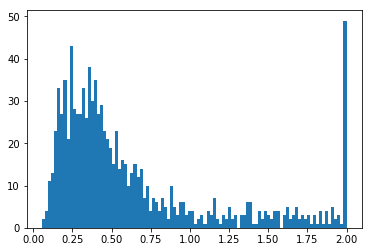

In [60]:
plt.hist(lst,bins=100);
print np.mean(lst) 

4480.5 5231.1 0.178588


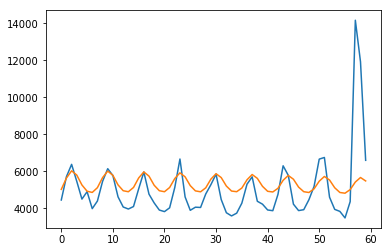

In [65]:
i=1
u=Y[i][:60]
v=a[i]
plt.plot(u)
plt.plot(v)
print np.median(u),np.median(v), (2*np.abs(u-v)/(np.abs(u)+np.abs(v))).mean()

200.5 3429.59 1.62789


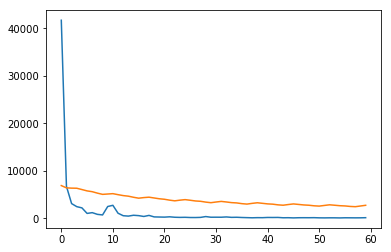

In [62]:
i=50
u=Y[i][:60]
v=a[i]
plt.plot(u)
plt.plot(v)
print np.median(u),np.median(v), (2*np.abs(u-v)/(np.abs(u)+np.abs(v))).mean()

682.5 1145.24 1.01884


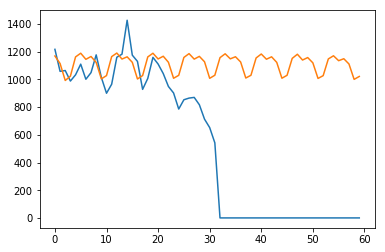

In [63]:
i=400
u=Y[i][:60]
v=a[i]
plt.plot(u)
plt.plot(v)
print np.median(u),np.median(v), (2*np.abs(u-v)/(np.abs(u)+np.abs(v))).mean()

39.5 52.6819 0.502697


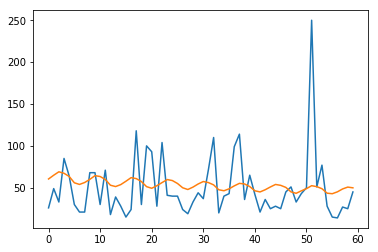

In [64]:
i=809
u=Y[i][:60]
v=a[i]
plt.plot(u)
plt.plot(v)
print np.median(u),np.median(v), (2*np.abs(u-v)/(np.abs(u)+np.abs(v))).mean()